# Mediapipe inference on static Yoga pose image dataset

In [2]:
import json
import cv2

def load_coco_annotations(coco_json_path):
    with open(coco_json_path) as f:
        coco_data = json.load(f)
    return coco_data

# Replace with your JSON file path
coco_json_path = 'Yoga poses.v2i.coco/test/_annotations.coco.json'
coco_data = load_coco_annotations(coco_json_path)

## Loading model

In [3]:
import mediapipe as mp

mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True)

def process_image(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)
    return results, image_rgb

# Replace with your image path
image_path = 'Yoga poses.v2i.coco/test/test1.jpg'
results, image_rgb = process_image(image_path)

2024-09-22 21:14:07.455418: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-22 21:14:11.646954: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-22 21:14:11.655554: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-22 21:14:17.939641: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
I0000 00:00:1727050472.594383    4289 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1727050472.621715   11259 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.107.02), renderer: NVIDIA GeForce RTX 3070/PCIe/SSE2
INFO: Created TensorFlow Lite X

## Dataset pre-processing

In [4]:
def extract_mediapipe_keypoints(results, image_shape):
    if results.pose_landmarks:
        keypoints = []
        for landmark in results.pose_landmarks.landmark:
            x = int(landmark.x * image_shape[1])
            y = int(landmark.y * image_shape[0])
            keypoints.append((x, y))
        return keypoints
    else:
        return [(0, 0)] * 17  # assuming 17 keypoints in COCO format

image_shape = (image_rgb.shape[0], image_rgb.shape[1])
mp_keypoints = extract_mediapipe_keypoints(results, image_shape)


def filter_keypoints(results, indices):
    if results.pose_landmarks:
        keypoints = []
        for i in indices:
            landmark = results.pose_landmarks.landmark[i]
            x, y = int(landmark.x * image_width), int(landmark.y * image_height)
            keypoints.append((x, y))
        return keypoints
    return None

# Define the indices for the 13 keypoints we need
# Using MediaPipe indices: 
# 0: Nose, 11: Left Shoulder, 12: Right Shoulder, 23: Left Hip, 24: Right Hip, 
# 25: Left Knee, 26: Right Knee, 27: Left Ankle, 28: Right Ankle, 13: Left Elbow, 14: Right Elbow,
# 15: Left Wrist, 16: Right Wrist

selected_indices = [0, 11, 12, 23, 24, 25, 26, 27, 28, 13, 14, 15, 16]

# Process the image and filter the keypoints
image_height, image_width, _ = image_rgb.shape
mp_keypoints = filter_keypoints(results, selected_indices)

print(mp_keypoints)

def coco_keypoints_to_xy(keypoints, width, height):
    # Extract x, y coordinates from keypoints
    keypoints_xy = []
    for i in range(0, len(keypoints), 3):
        x, y = keypoints[i], keypoints[i + 1]
        keypoints_xy.append((int(x), int(y)))
    return keypoints_xy

def extract_keypoints_by_image_id(coco_data, image_id):
    keypoints_by_image = []

    # Loop through annotations
    for ann in coco_data['annotations']:
        if ann['image_id'] == image_id:
            # Get the keypoints and convert them to (x, y) format
            keypoints_xy = coco_keypoints_to_xy(ann['keypoints'], image_shape[1], image_shape[0])
            keypoints_by_image.extend(keypoints_xy)

    return keypoints_by_image

# Example usage
image_id_to_extract = 13    # Replace with the image ID you want to extract, check annotations file
image_shape = (640, 640)
gt_keypoints = extract_keypoints_by_image_id(coco_data, image_id_to_extract)


print(gt_keypoints)


[(264, 234), (308, 267), (295, 260), (320, 398), (288, 393), (425, 455), (163, 393), (537, 494), (159, 496), (308, 198), (297, 195), (325, 125), (318, 132)]
[(285, 226), (256, 275), (311, 280), (320, 380), (275, 390), (151, 391), (397, 458), (163, 494), (530, 490), (298, 184), (330, 114), (277, 188), (325, 110)]


## Define metrics

In [63]:
import numpy as np
from sklearn.metrics import pairwise_distances

def calculate_oks(gt_keypoints, pred_keypoints, bbox_area, indices):
    sigmas = np.array([0.26, 0.25, 0.25, 0.35, 0.35, 0.79, 0.79, 0.72, 0.72, 0.62, 0.62, 0.79, 0.79, 0.72, 0.72, 0.62, 0.62])

    #Filter keypoints
    selected_sigmas = []

    for j in indices:
        selected_sigmas.append(sigmas[j])

    #print("gt_kpts: ", gt_keypoints)

    # Ensure both keypoints lists have exactly 13 keypoints
    gt_keypoints = gt_keypoints[:13]
    pred_keypoints = pred_keypoints[:13]

    y_true = np.array(gt_keypoints).reshape(-1, 2)
    y_pred = np.array(pred_keypoints).reshape(-1, 2)

    #print("ytrue: ", y_true)
    #print("ypred: ", y_pred)

    # Handle cases where there might be fewer keypoints
    if y_true.shape[0] != y_pred.shape[0]:
        raise ValueError(f"Shape mismatch between ground truth and predicted keypoints: {y_true.shape} vs {y_pred.shape}")


    # Calculate Euclidean distance between keypoints
    d2 = (y_true - y_pred)**2 
    # d^2 = (x1 - x2)^2 + (y1 - y2)^2
    d2_sum = d2.sum(axis=1)

    #print(d2_sum)
    

    # Adjust sigmas shape if necessary
    if sigmas.shape[0] != d2.shape[1]:
        sigmas = sigmas[:d2.shape[1]]

    # COCO assigns k = 2σ.
    for i in range(len(selected_sigmas)):
        selected_sigmas[i] = 2 * selected_sigmas[i]

    #print(selected_sigmas)

    denom=[]
    # Denominator in the exponent term. Shape: [M, 1, #kpts]
    for k in range(len(selected_sigmas)):
        denom.append( 2 * (selected_sigmas[k]**2) * bbox_area )
    
    #print( -d2_sum/denom )

    # Calculate OKS
    oks = np.exp(-d2_sum / denom )

    print(oks)

    return oks.mean()

"""
def calculate_pcp(gt_keypoints, pred_keypoints):
    # Ensure both keypoints lists have exactly 13 keypoints
    gt_keypoints = gt_keypoints[:13]
    pred_keypoints = pred_keypoints[:13]

    # Handle missing keypoints by replacing them with a placeholder
    def handle_missing_keypoints(keypoints):
        return [(0, 0) if k == (0, 0) else k for k in keypoints]

    gt_keypoints = handle_missing_keypoints(gt_keypoints)
    pred_keypoints = handle_missing_keypoints(pred_keypoints)

    correct_parts = 0
    total_parts = 0
    
    # Define limb pairs (COCO has pairs like [5,7] for left upper arm, [11,13] for left upper leg, etc.)
    limb_pairs = [(5, 7), (7, 9), (6, 8), (8, 10), (11, 13), (13, 15), (12, 14), (14, 16)]
    
    for (i, j) in limb_pairs:
        # Skip the part if either keypoint in the pair is missing
        if gt_keypoints[i] == (0, 0) or gt_keypoints[j] == (0, 0):
            continue
        
        gt_dist = np.linalg.norm(np.array(gt_keypoints[i]) - np.array(gt_keypoints[j]))
        pred_dist = np.linalg.norm(np.array(pred_keypoints[i]) - np.array(pred_keypoints[j]))
        
        # Check if the predicted distance is within a threshold (example: 50% of ground truth distance)
        if abs(gt_dist - pred_dist) / gt_dist < 0.5:
            correct_parts += 1
        total_parts += 1
    
    if total_parts == 0:
        return 0.0  # No parts to compare, return 0 PCP

    pcp = correct_parts / total_parts
    return pcp
"""

'\ndef calculate_pcp(gt_keypoints, pred_keypoints):\n    # Ensure both keypoints lists have exactly 13 keypoints\n    gt_keypoints = gt_keypoints[:13]\n    pred_keypoints = pred_keypoints[:13]\n\n    # Handle missing keypoints by replacing them with a placeholder\n    def handle_missing_keypoints(keypoints):\n        return [(0, 0) if k == (0, 0) else k for k in keypoints]\n\n    gt_keypoints = handle_missing_keypoints(gt_keypoints)\n    pred_keypoints = handle_missing_keypoints(pred_keypoints)\n\n    correct_parts = 0\n    total_parts = 0\n    \n    # Define limb pairs (COCO has pairs like [5,7] for left upper arm, [11,13] for left upper leg, etc.)\n    limb_pairs = [(5, 7), (7, 9), (6, 8), (8, 10), (11, 13), (13, 15), (12, 14), (14, 16)]\n    \n    for (i, j) in limb_pairs:\n        # Skip the part if either keypoint in the pair is missing\n        if gt_keypoints[i] == (0, 0) or gt_keypoints[j] == (0, 0):\n            continue\n        \n        gt_dist = np.linalg.norm(np.array(gt_

## Calculate Metrics

In [64]:
area=640*640*0.53   #average area of the bounding box

# Indices for joints in COCO format
coco_indices = [0, 5, 6, 11, 12, 13, 14, 15, 16, 7, 8, 9, 10]

# Calculate OKS
oks = calculate_oks(gt_keypoints, mp_keypoints, area, coco_indices)
print(f"OKS: {oks:.4f}")

# Calculate PCP
#pcp = calculate_pcp(gt_keypoints, mp_keypoints)
#print(f"PCP: {pcp:.4f}")


[0.99570775 0.99744946 0.99939495 0.99970112 0.99983579 0.91581687
 0.93658774 0.81097008 0.81364577 0.99967128 0.9915389  0.99064751
 0.99920192]
OKS: 0.9577


## Inference on image

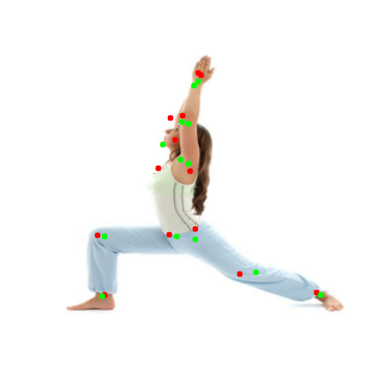

In [5]:
import matplotlib.pyplot as plt

# Draw keypoint comparison on the image
for x, y in gt_keypoints:
    cv2.circle(image_rgb, (int(x), int(y)), 5, (255, 0, 0), -1)  # Red circles for ground truth keypoints

for x,y in mp_keypoints:
    cv2.circle(image_rgb, (int(x), int(y)), 5, (0, 255, 0), -1)  # Green circles for predicted keypoints

# Display the image with keypoints
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

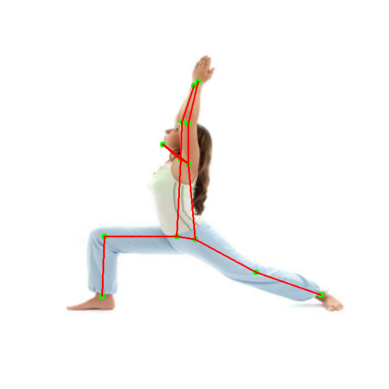

In [10]:
connections = [
    (0, 1),  # Nose -> Left Shoulder
    (1, 9),  # Left Shoulder -> Left Elbow
    (9, 11), # Left Elbow -> Left Wrist
    (0, 2),  # Nose -> Right Shoulder
    (2, 10), # Right Shoulder -> Right Elbow
    (10, 12),# Right Elbow -> Right Wrist
    (1, 3),  # Left Shoulder -> Left Hip
    (2, 4),  # Right Shoulder -> Right Hip
    (3, 5),  # Left Hip -> Left Knee
    (5, 7),  # Left Knee -> Left Ankle
    (4, 6),  # Right Hip -> Right Knee
    (6, 8),   # Right Knee -> Right Ankle
    (1, 2),   # Left Shoulder -> Right Shoulder
    (3, 4)   # Left Hip -> Right Hip
]

# Visualization of the filtered keypoints with skeleton lines
plt.imshow(image_rgb)
for x, y in mp_keypoints:
    cv2.circle(image_rgb, (x, y), 5, (0, 255, 0), -1)

for start_idx, end_idx in connections:
    start_point = mp_keypoints[start_idx]
    end_point = mp_keypoints[end_idx]
    cv2.line(image_rgb, start_point, end_point, (255, 0, 0), 2)  # Blue line with thickness 2

plt.axis('off')
plt.show()
